<a href="https://colab.research.google.com/github/mwierciszewska/TensorFlow_lab/blob/main/Food_vision_project_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Food vision project with tensorflow** - using tensorflow dataset food101

In [11]:
import tensorflow_datasets as tfds

In [12]:
#Load the data from TensorFlow dataset
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [13]:
import os

In [ ]:
if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/mwierciszewska/TensorFlow_lab/refs/heads/main/extras/helper_functions.py
else:
  print(" 'helepr_function.py' already exists.")

In [ ]:
#Exploring sample data from dataset

In [14]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [15]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [16]:
one_sample = train_data.take(1)

In [17]:
one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from food101: {label}
  Class names: {class_names[label.numpy()]}
  """
  )


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from food101: 56
  Class names: huevos_rancheros
  


In [18]:
import tensorflow as tf

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

In [ ]:
#Ploting sample image from dataset

In [19]:
import matplotlib.pyplot as plt

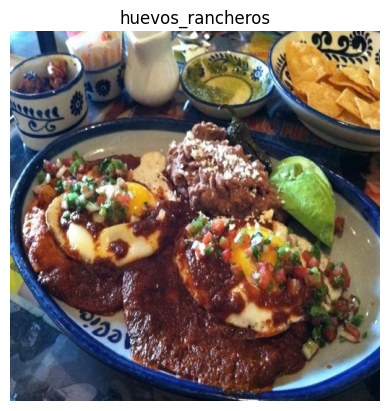

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [ ]:
#Preprocessing data

In [ ]:
#First checking on sample image

In [20]:
def preprocessing_img(image, label, img_shape=224):
  """
  Convert image datatype from uint8 to float32 and reshape image to [img_shape, img_shape, 3]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
preprocessed_img = preprocessing_img(image, label)[0]

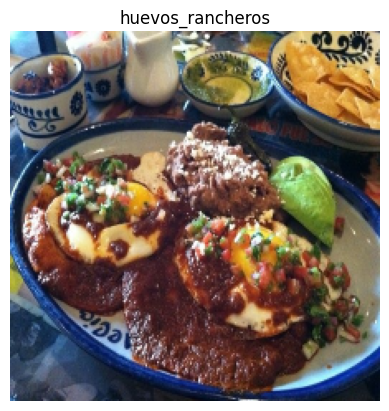

In [ ]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [ ]:
#Prepare all datasets

In [21]:
train_data = train_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
test_data = test_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
#Create checkpoint callbacks

In [ ]:
checkpoint_path = 'model_checkpoints/cp.weights.keras'

In [ ]:
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor='val_acc',
                                                     save_best_only=True,
                                                     save_weights_only=True)

In [ ]:
#Turn on mixed precision training

In [25]:
from tensorflow.keras import mixed_precision

In [26]:
mixed_precision.set_global_policy(policy='mixed_float16')

In [ ]:
#Buliding feature extraction model using EfficiontNet - base model

In [27]:
from tensorflow.keras import layers

In [ ]:
def make_model():

  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetB1(include_top=False)
  base_model.trainable = False

  inputs = layers.Input(shape=input_shape, name='input_layer')
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D(name='average_pooling_layer')(x)
  x = layers.Dense(len(class_names))(x)
  outputs = layers.Activation('softmax', dtype=tf.float32, name='activation_softmax_float32_layer')(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
model = make_model()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_softmax_float32_layer     │ (None, 101)                 │               0 │
│ (Activation)                         │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,704,620 (25.58 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 6,575,239 (25.08 MB)

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb1 False float32 <DTypePolicy "mixed_float16">
average_pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
activation_softmax_float32_layer True float32 <DTypePolicy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

In [ ]:
history = model.fit(train_data,
                    epochs=4,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[model_checkpoints]
                    )

Epoch 1/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 302s 104ms/step - accuracy: 0.4774 - loss: 2.2708 - val_accuracy: 0.6827 - val_loss: 1.1577
Epoch 2/4


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 251s 86ms/step - accuracy: 0.6637 - loss: 1.2935 - val_accuracy: 0.7156 - val_loss: 1.0476
Epoch 3/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 87ms/step - accuracy: 0.6937 - loss: 1.1595 - val_accuracy: 0.7296 - val_loss: 1.0045
Epoch 4/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 172s 72ms/step - accuracy: 0.7222 - loss: 1.0500 - val_accuracy: 0.7275 - val_loss: 0.9916


In [ ]:
results = model.evaluate(test_data)
results

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.7261 - loss: 1.0003


[1.0054693222045898, 0.7249900698661804]

In [ ]:
model.save('feature_extract_food_vision_model.keras')

In [ ]:
#fine tuning the model

In [ ]:
# create EarlyStopping callback

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [ ]:
#create new ModelCheckPoint callback for fine tuning model

In [ ]:
checkpoint_path_ft = 'fine_tune_checkpoints/cp.weights.keras'

In [ ]:
model_ft_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_ft, save_best_only=True, monitor='val_loss')

In [ ]:
#create reduction learning rate callback

In [29]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss', mode='min', min_lr=1e-7)

In [ ]:
model_ft = tf.keras.models.load_model('feature_extract_food_vision_model.keras')

In [ ]:
model_ft.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_7 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_softmax_float32_layer     │ (None, 101)                 │               0 │
│ (Activation)                         │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,963,388 (26.56 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 6,575,239 (25.08 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [ ]:
for layer in model_ft.layers[1].layers[-15:]:
  layer.trainable=True

In [ ]:
for layer in model_ft.layers[1].layers:
  print(layer.name, layer.trainable)

input_layer True
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
bl

In [ ]:
model_ft.compile(loss='sparse_categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(0.0001), #lower lr for fine-tuning
                 metrics=['accuracy'])

In [ ]:
history_ft = model_ft.fit(train_data,
                       epochs=100,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(0.15*len(test_data)),
                       callbacks=[early_stopping,model_ft_checkpoint,reduce_lr])

Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 259s 87ms/step - accuracy: 0.7196 - loss: 1.0613 - val_accuracy: 0.7572 - val_loss: 0.8940 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 176s 73ms/step - accuracy: 0.7728 - loss: 0.8447 - val_accuracy: 0.7595 - val_loss: 0.8640 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 177s 73ms/step - accuracy: 0.7992 - loss: 0.7506 - val_accuracy: 0.7640 - val_loss: 0.8507 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 98ms/step - accuracy: 0.8225 - loss: 0.6673 - val_accuracy: 0.7614 - val_loss: 0.8463 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 261s 98ms/step - accuracy: 0.8434 - loss: 0.5894 - val_accuracy: 0.7643 - val_loss: 0.8568 - learning_rate: 1.0000e-04
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.8585 - loss: 0.5315 - val_accuracy: 0.7651 - val_loss: 0.8477 - learning_rate: 1.0000e-04
Epoch 7/100
2368/2368 ━━━━━━

In [ ]:
model_ft.save('fine_tuned_food_vision_model.keras')

In [ ]:
#Checking results

In [ ]:
results_model_ft = model_ft.evaluate(test_data)
results_model_ft

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.7687 - loss: 0.8736


[0.8769713640213013, 0.7668514847755432]

In [ ]:
#checking the model on my own photos of food

In [136]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

In [ ]:
!wget https://github.com/mwierciszewska/TensorFlow_lab/blob/main/extras/IMG_0897.jpeg
!wget https://github.com/mwierciszewska/TensorFlow_lab/blob/main/extras/IMG_1201.jpeg
!wget https://github.com/mwierciszewska/TensorFlow_lab/blob/main/extras/IMG_2672.jpeg

--2025-03-20 18:37:36--  https://github.com/mwierciszewska/TensorFlow_lab/blob/main/extras/IMG_0897.jpeg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘IMG_0897.jpeg.1’

IMG_0897.jpeg.1         [  <=>               ] 200.88K   833KB/s    in 0.2s    

2025-03-20 18:37:37 (833 KB/s) - ‘IMG_0897.jpeg.1’ saved [205703]

--2025-03-20 18:37:37--  https://github.com/mwierciszewska/TensorFlow_lab/blob/main/extras/IMG_1201.jpeg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘IMG_1201.jpeg.1’

IMG_1201.jpeg.1         [  <=>               ] 201.01K   822KB/s    in 0.2s    

2025-03-20 18:37:38 (822 KB/s) - ‘IMG_1201.jpeg.1’ saved [205839]

--2025-03-20 18:37:38--  https://git

In [137]:
my_own_food_images = ['/content/IMG_0897.jpeg', '/content/IMG_1201.jpeg', '/content/IMG_2672.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


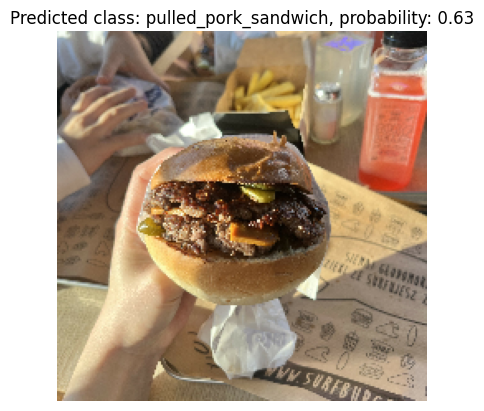

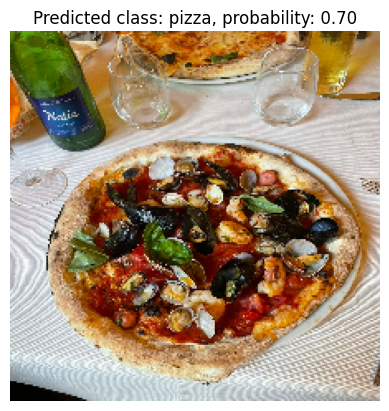

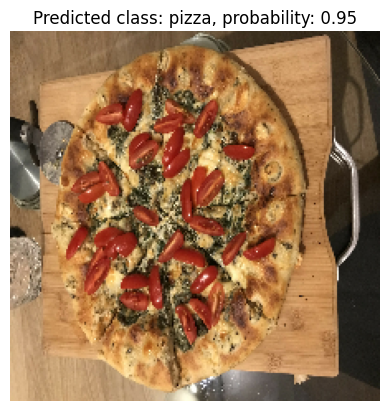

In [ ]:
for image in my_own_food_images:
  img = load_and_prep_image(image, scale=False)
  pred_prob = model_ft.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Predicted class: {pred_class}, probability: {pred_prob.max():.2f}")
  plt.axis(False)

In [ ]:
#continue fine-tuning

In [30]:
model_ft_2 = tf.keras.models.load_model('/content/fine_tuned_food_vision_model.keras')

In [31]:
model_ft_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_softmax_float32_layer     │ (None, 101)                 │               0 │
│ (Activation)                         │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,678,428 (36.92 MB)

 Trainable params: 1,486,901 (5.67 MB)

 Non-trainable params: 5,217,719 (19.90 MB)

 Optimizer params: 2,973,808 (11.34 MB)

In [32]:
for layer in model_ft_2.layers[1].layers:
  print(layer.name, layer.trainable)

input_layer True
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
bl

In [35]:
for layer in model_ft_2.layers[1].layers[-50:]:
  layer.trainable=True

In [36]:
for layer in model_ft_2.layers[1].layers:
  print(layer.name, layer.trainable)

input_layer True
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
bl

In [37]:
model_ft_2.compile(loss='sparse_categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(0.0001), #lower lr for fine-tuning
                 metrics=['accuracy'])

In [38]:
history_ft_2 = model_ft_2.fit(train_data,
                       epochs=100,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(0.15*len(test_data)),
                       callbacks=[early_stopping,reduce_lr])

Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 270s 88ms/step - accuracy: 0.8081 - loss: 0.6826 - val_accuracy: 0.7659 - val_loss: 0.8778 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 197s 82ms/step - accuracy: 0.9138 - loss: 0.3278 - val_accuracy: 0.7730 - val_loss: 0.8743 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 174s 72ms/step - accuracy: 0.9330 - loss: 0.2613 - val_accuracy: 0.7797 - val_loss: 0.8656 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 261s 98ms/step - accuracy: 0.9447 - loss: 0.2205 - val_accuracy: 0.7712 - val_loss: 0.8806 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.9549 - loss: 0.1836 - val_accuracy: 0.7797 - val_loss: 0.8861 - learning_rate: 1.0000e-04
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 166s 69ms/step - accuracy: 0.9606 - loss: 0.1614 - val_accuracy: 0.7812 - val_loss: 0.8572 - learning_rate: 1.0000e-04
Epoch 7/100
2368/2368 ━━━━━━

In [39]:
results_model_ft_2 = model_ft_2.evaluate(test_data)
results_model_ft_2

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.7832 - loss: 0.8870


[0.891129732131958, 0.7822574377059937]

In [42]:
model_ft_2.save('final_food_vision_model.keras')

In [98]:
#Load the data from TensorFlow dataset
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

In [100]:
test_data = test_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
y_pred_probs = model_ft_2.predict(test_data)
y_pred = y_pred_probs.argmax(axis=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step


In [102]:
y_pred[:10]

array([ 29,  81,  91,  53,  97,  31,  10,  31,   3, 100])

In [103]:
y_true = []
for image, labels in test_data.unbatch():
    y_true.append(int(labels.numpy()))

In [104]:
y_true[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [105]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [106]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Szczegółowy raport klasyfikacji
print(classification_report(y_true, y_pred))

Accuracy: 0.7823
              precision    recall  f1-score   support

           0       0.68      0.51      0.58       250
           1       0.78      0.78      0.78       250
           2       0.82      0.83      0.82       250
           3       0.75      0.86      0.80       250
           4       0.70      0.71      0.70       250
           5       0.67      0.66      0.67       250
           6       0.88      0.82      0.85       250
           7       0.88      0.93      0.90       250
           8       0.55      0.62      0.58       250
           9       0.73      0.70      0.71       250
          10       0.71      0.66      0.68       250
          11       0.83      0.79      0.81       250
          12       0.84      0.80      0.82       250
          13       0.73      0.84      0.78       250
          14       0.78      0.72      0.75       250
          15       0.62      0.57      0.59       250
          16       0.65      0.67      0.66       250
          

In [107]:
from helper_functions import make_confusion_matrix

In [114]:
make_confusion_matrix(y_true, y_pred, figsize=(100,100), text_size=25)

In [115]:
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)

In [121]:
class_f1_score= {}

for key, value in classification_report_dict.items():
  if key == 'accuracy':
    break
  else:
    class_f1_score[class_names[int(key)]] = value['f1-score']

In [122]:
class_f1_score

{'apple_pie': 0.5825688073394495,
 'baby_back_ribs': 0.776,
 'baklava': 0.8230616302186878,
 'beef_carpaccio': 0.7985074626865671,
 'beef_tartare': 0.7023809523809523,
 'beet_salad': 0.6653225806451613,
 'beignets': 0.8512396694214877,
 'bibimbap': 0.9044834307992202,
 'bread_pudding': 0.5811320754716981,
 'breakfast_burrito': 0.7142857142857143,
 'bruschetta': 0.6833333333333333,
 'caesar_salad': 0.8106995884773662,
 'cannoli': 0.8172484599589322,
 'caprese_salad': 0.7829313543599258,
 'carrot_cake': 0.7510373443983402,
 'ceviche': 0.592901878914405,
 'cheesecake': 0.6588235294117647,
 'cheese_plate': 0.8387096774193549,
 'chicken_curry': 0.7283236994219653,
 'chicken_quesadilla': 0.7895791583166333,
 'chicken_wings': 0.834307992202729,
 'chocolate_cake': 0.6837944664031621,
 'chocolate_mousse': 0.556,
 'churros': 0.8825910931174089,
 'clam_chowder': 0.8537074148296593,
 'club_sandwich': 0.8439306358381503,
 'crab_cakes': 0.6355140186915887,
 'creme_brulee': 0.8433268858800773,
 'croq

In [124]:
import pandas as pd

In [127]:
f1_scores = pd.DataFrame({"class_name": list(class_f1_score.keys()),
                          "f1-score": list(class_f1_score.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33        edamame  0.992032
63       macarons  0.952191
69        oysters  0.924901
45  frozen_yogurt  0.911197
65        mussels  0.908000

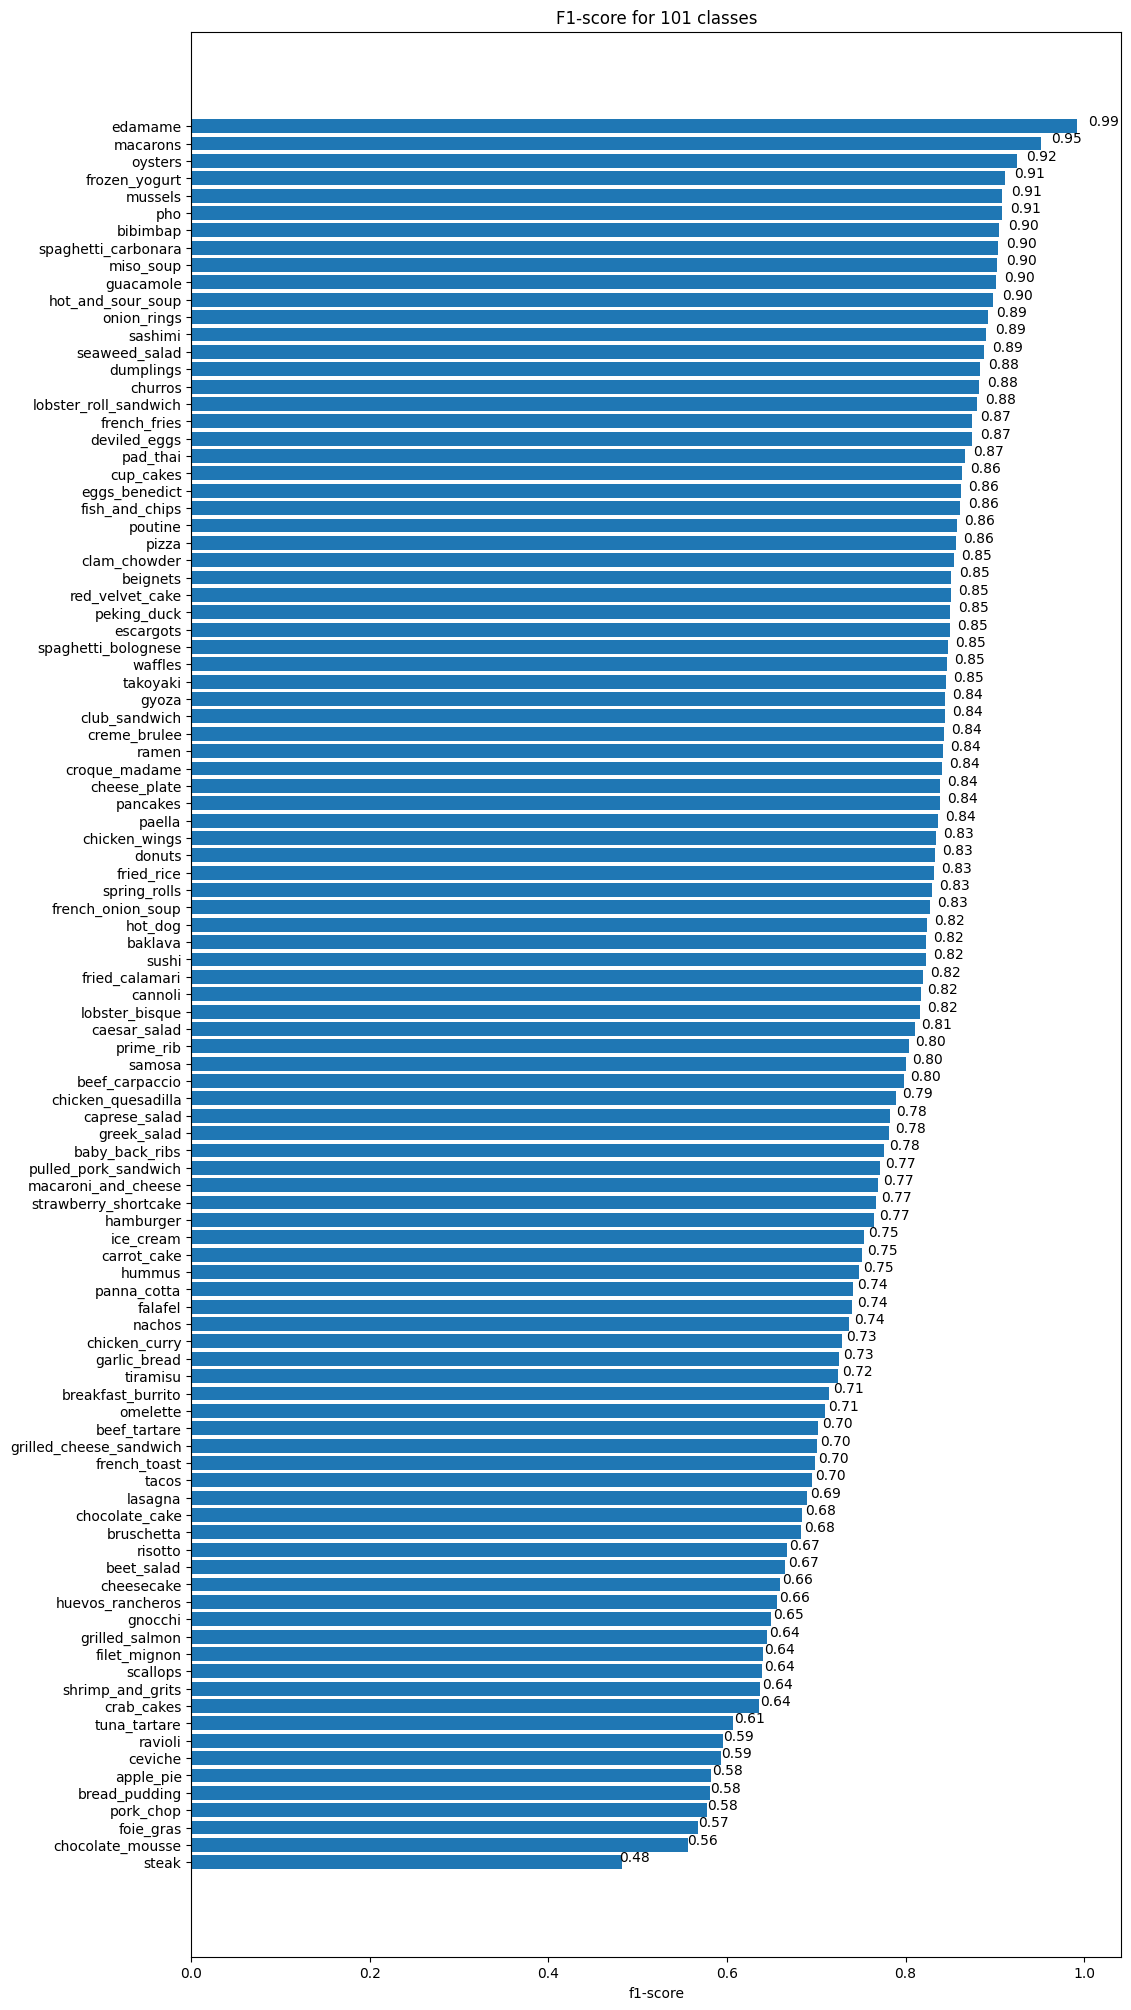

In [131]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)),f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores['class_name']))
ax.set_xlabel('f1-score')
ax.set_title('F1-score for 101 classes')
ax.invert_yaxis();

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)